In [1]:
import pandas as pd
import numpy as np
import json 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import tree, model_selection, metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error
from sklearn.preprocessing import OneHotEncoder


In [2]:
df = pd.read_csv("Output/Combined_dataset.csv")
df = df.drop('Unnamed: 0', axis=1)
print(df.shape)

df['duration'] = pd.to_numeric(pd.to_timedelta(df['duration']).dt.days, downcast='integer')
df['num_faq'] = df['num_faq'].astype(int)
df['n_comments'] = df['n_comments'].str.replace(',', '').astype(float)
df.sample(1)

(1000, 32)


,backers_count,blurb,category,converted_pledged_amount,country,created_at,current_currency,deadline,fx_rate,goal,...,static_usd_rate,urls,usd_pledged,usd_type,story,faq,num_faq,comments,n_comments,duration
836,120,"Curb hunger naturally, not chemically, with th...","{""id"":307,""name"":""Drinks"",""slug"":""food/drinks""...",26578,US,2015-05-17 11:55,USD,2015-06-25 23:00,1.0,25000,...,1.0,"{""web"":{""project"":""https://www.kickstarter.com...",26578.0,international,"We want to make your day easier, your workout ...",[' What are the ingredients? Ingredients: wate...,1,Only backers can post comments. Log in\nHelena...,6.0,28


In [3]:
df.columns

Index(['backers_count', 'blurb', 'category', 'converted_pledged_amount',
       'country', 'created_at', 'current_currency', 'deadline', 'fx_rate',
       'goal', 'id', 'launched_at', 'location', 'name', 'pledged', 'profile',
       'slug', 'source_url', 'spotlight', 'staff_pick', 'state',
       'state_changed_at', 'static_usd_rate', 'urls', 'usd_pledged',
       'usd_type', 'story', 'faq', 'num_faq', 'comments', 'n_comments',
       'duration'],
      dtype='object')

### Feature Engineering

In [4]:
# Get month/year of launch/deadline
df['month_launched'] = pd.DatetimeIndex(df['launched_at']).month.astype(int)
df['year_launched'] = pd.DatetimeIndex(df['launched_at']).year.astype(int)
df['month_deadline'] = pd.DatetimeIndex(df['deadline']).month.astype(int)
df['year_deadline'] = pd.DatetimeIndex(df['deadline']).year.astype(int)
 
# Convert rows from str to dict
def string_to_dict(dict_string):
    # Convert to proper json format
    dict_string = dict_string.replace("'", "'").replace('u"', '"')
    return json.loads(dict_string)

df.category = df.category.apply(string_to_dict)

# Get category values from dictionary
df['parent_category'] = [d.get('parent_name') for d in df.category]
df['category_name'] = [d.get('name') for d in df.category]
df["parent_category"].fillna("No Parent Category", inplace = True)

# Fill na for text cols
df["story"].fillna(" ", inplace = True)

df.state = df.state.astype('category').cat.codes

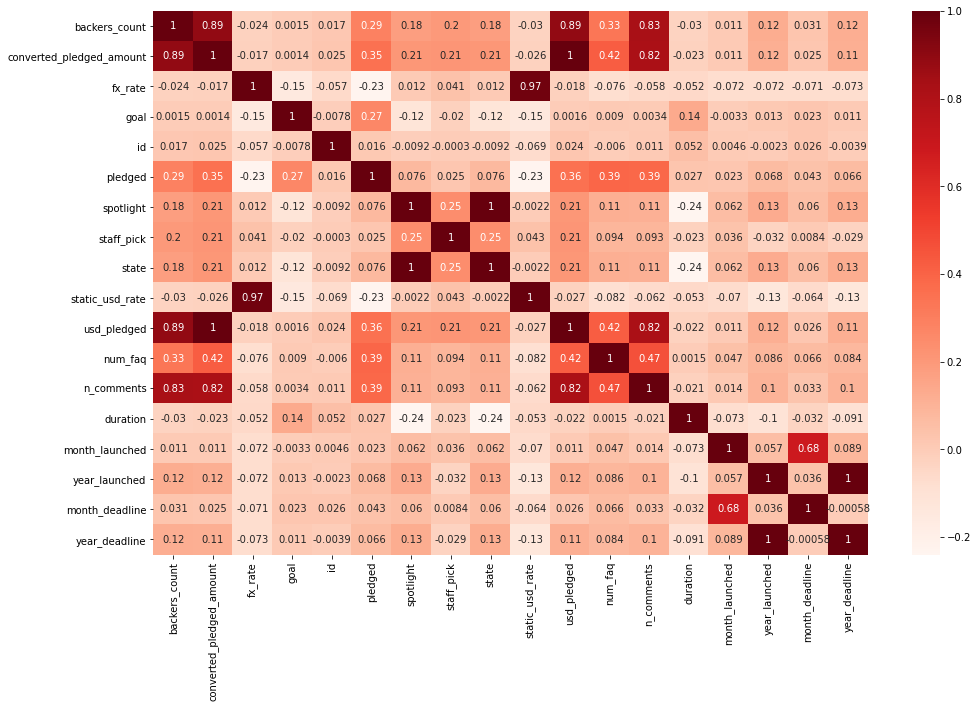

In [5]:
plt.figure(figsize=(16,10))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [6]:
cols_to_drop = ['profile', 'category', 'created_at', 'location', 'current_currency', 'deadline', 'id', 'launched_at', 'slug', 'source_url', 'state_changed_at', 'urls', 'static_usd_rate', 'usd_pledged', 'converted_pledged_amount', 'spotlight', 'month_deadline', 'year_deadline']
df = df.drop(cols_to_drop, axis=1)

In [7]:
categorical_cols = ['country', 'staff_pick', 'usd_type', 'parent_category', 'category_name']
num_cols = ['backers_count', 'fx_rate', 'goal', 'pledged', 'num_faq', 'n_comments', 'duration', 'month_launched', 'year_launched']
text_cols = ['blurb', 'name', 'story', 'faq', 'comments']

In [8]:
# Text Analysis
from textblob import TextBlob

# define a function that accepts text and returns the polarity
def detect_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

# create a new DataFrame column for sentiment 
for col in text_cols:
    col_name = col + '_sentiment'
    df[col_name] = df[col].apply(detect_sentiment)
    
df = df.drop(text_cols, axis=1)
df.head(3)

,backers_count,country,fx_rate,goal,pledged,staff_pick,state,usd_type,num_faq,n_comments,duration,month_launched,year_launched,parent_category,category_name,blurb_sentiment,name_sentiment,story_sentiment,faq_sentiment,comments_sentiment
0,1,ES,1.212886,15000,1.0,False,0,domestic,0,0.0,30,6,2016,Technology,3D Printing,0.0,0.0,0.160156,0.0,0.0
1,2,NZ,0.723585,5000,15.0,False,0,domestic,0,0.0,30,8,2015,Food,Farms,0.2,0.4,0.357143,0.0,0.0
2,0,US,1.000000,10000,0.0,False,0,domestic,0,0.0,29,4,2015,Art,Mixed Media,0.5,0.5,0.143182,0.0,0.0


### Feature Transformation

In [17]:
# Split dataset
X = df.drop('state', axis=1)
y = df.state

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=2019)

In [18]:
# One Hot Encoding with training set only
from pandas.api.types import CategoricalDtype 

OHE_df = pd.DataFrame()

for i in categorical_cols:
    OHE_df[i] = X_train[i].astype(CategoricalDtype(list(set(X[i]))))
    
    OHE_df = pd.concat([OHE_df, pd.get_dummies(X[i], prefix=i)],axis=1)

In [19]:
OHE_df = OHE_df.drop(categorical_cols, axis= 1)

X_no_cat = X.drop(categorical_cols, axis= 1)
OHE_df = pd.concat([X_no_cat, OHE_df],axis=1)

In [20]:
OHE_train, OHE_test, y_train, y_test = model_selection.train_test_split(OHE_df, y, test_size=0.2, random_state=2019)

In [22]:
OHE_df

,backers_count,fx_rate,goal,pledged,num_faq,n_comments,duration,month_launched,year_launched,blurb_sentiment,...,category_name_Spaces,category_name_Stationery,category_name_Tabletop Games,category_name_Television,category_name_Video,category_name_Video Games,category_name_Web,category_name_Workshops,category_name_World Music,category_name_Young Adult
0,1,1.212886,15000,1.00,0,0.0,30,6,2016,0.000000,...,0,0,0,0,0,0,0,0,0,0
1,2,0.723585,5000,15.00,0,0.0,30,8,2015,0.200000,...,0,0,0,0,0,0,0,0,0,0
2,0,1.000000,10000,0.00,0,0.0,29,4,2015,0.500000,...,0,0,0,0,0,0,0,0,0,0
3,0,1.000000,2000,0.00,0,0.0,30,9,2014,0.150000,...,0,0,0,0,0,0,0,0,0,0
4,10,1.000000,2500,340.00,0,1.0,30,11,2014,0.200000,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,12,1.000000,225,386.00,0,0.0,12,5,2016,0.250000,...,0,0,0,0,0,0,0,0,0,0
996,36,1.000000,4000,4230.00,0,0.0,30,9,2012,0.568182,...,0,0,0,0,0,0,0,0,0,0
997,28,1.000000,2500,2516.00,0,0.0,22,6,2018,0.000000,...,0,0,0,0,0,0,0,0,0,0
998,3,1.000000,20,51.00,0,2.0,25,8,2017,-0.055556,...,0,0,0,0,0,0,0,0,0,0


In [30]:
OHE_df # _sentiment cols

,backers_count,fx_rate,goal,pledged,num_faq,n_comments,duration,month_launched,year_launched,blurb_sentiment,...,category_name_Spaces,category_name_Stationery,category_name_Tabletop Games,category_name_Television,category_name_Video,category_name_Video Games,category_name_Web,category_name_Workshops,category_name_World Music,category_name_Young Adult
0,1,1.212886,15000,1.00,0,0,30,6,2016,0.000000,...,0,0,0,0,0,0,0,0,0,0
1,2,0.723585,5000,15.00,0,0,30,8,2015,0.200000,...,0,0,0,0,0,0,0,0,0,0
2,0,1.000000,10000,0.00,0,0,29,4,2015,0.500000,...,0,0,0,0,0,0,0,0,0,0
3,0,1.000000,2000,0.00,0,0,30,9,2014,0.150000,...,0,0,0,0,0,0,0,0,0,0
4,10,1.000000,2500,340.00,0,1,30,11,2014,0.200000,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,12,1.000000,225,386.00,0,0,12,5,2016,0.250000,...,0,0,0,0,0,0,0,0,0,0
996,36,1.000000,4000,4230.00,0,0,30,9,2012,0.568182,...,0,0,0,0,0,0,0,0,0,0
997,28,1.000000,2500,2516.00,0,0,22,6,2018,0.000000,...,0,0,0,0,0,0,0,0,0,0
998,3,1.000000,20,51.00,0,2,25,8,2017,-0.055556,...,0,0,0,0,0,0,0,0,0,0


In [29]:
OHE_df.columns.tolist()

['backers_count',
 'fx_rate',
 'goal',
 'pledged',
 'num_faq',
 'n_comments',
 'duration',
 'month_launched',
 'year_launched',
 'blurb_sentiment',
 'name_sentiment',
 'story_sentiment',
 'faq_sentiment',
 'comments_sentiment',
 'country_AT',
 'country_AU',
 'country_BE',
 'country_CA',
 'country_CH',
 'country_DE',
 'country_DK',
 'country_ES',
 'country_FR',
 'country_GB',
 'country_HK',
 'country_IE',
 'country_IT',
 'country_JP',
 'country_LU',
 'country_MX',
 'country_NL',
 'country_NO',
 'country_NZ',
 'country_SE',
 'country_SG',
 'country_US',
 'staff_pick_False',
 'staff_pick_True',
 'usd_type_domestic',
 'usd_type_international',
 'parent_category_Art',
 'parent_category_Comics',
 'parent_category_Crafts',
 'parent_category_Dance',
 'parent_category_Fashion',
 'parent_category_Film & Video',
 'parent_category_Food',
 'parent_category_Games',
 'parent_category_Journalism',
 'parent_category_Music',
 'parent_category_No Parent Category',
 'parent_category_Photography',
 'parent

In [36]:
int_cols = ['backers_count', 'num_faq', 'n_comments', 'duration', 'month_launched', 'year_launched']
OHE_df[int_cols] = OHE_df[int_cols].apply(lambda x: x.astype('int')) 

categorical_cols2 = []
for i in categorical_cols:
    categorical_cols2 += [col for col in OHE_df.columns if i in col]
    
OHE_df[categorical_cols2] = OHE_df[categorical_cols2].apply(lambda x: x.astype('category')) 

In [37]:
print(OHE_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Columns: 123 entries, backers_count to category_name_Young Adult
dtypes: category(109), float64(7), int32(6), int64(1)
memory usage: 202.7 KB
None


In [822]:
# # apply OneHotEncoder on categorical feature columns
# ohe = OneHotEncoder(handle_unknown = 'ignore') 

# X_train_ohe = ohe.fit_transform(X_train[categorical_cols]) 
# X_test_ohe = ohe.transform(X_test[categorical_cols])

# OHE_train = np.hstack((X_train.drop(categorical_cols, axis=1).values, X_train_ohe.toarray()))
# OHE_test = np.hstack((X_test.drop(categorical_cols, axis=1).values, X_test_ohe.toarray()))

### Text Analysis

In [594]:
# # Term Frequency (count the number of occurrences of each term in each document)
# # TfidfVectorizer (CountVectorizer + TfidfTransformer)
# from sklearn.feature_extraction.text import TfidfVectorizer
# vect = TfidfVectorizer()
# pd.DataFrame(vect.fit_transform(X.comments).toarray(), columns=vect.get_feature_names())

In [595]:
# from sklearn.naive_bayes import MultinomialNB
# from sklearn import metrics

# # define a function that accepts a vectorizer and calculates the accuracy
# def tokenize_test(vect, col):
    
#     # create document-term matrices using the vectorizer
#     X_train_dtm = vect.fit_transform(X_train[col])
#     X_test_dtm = vect.transform(X_test[col])
    
#     # print the number of features that were generated
#     print('Features: ', X_train_dtm.shape[1])
    
#     # use Multinomial Naive Bayes to predict the star rating
#     nb = MultinomialNB()
#     nb.fit(X_train_dtm, y_train)
#     y_pred_class = nb.predict(X_test_dtm)
    
#     # print the accuracy of its predictions
#     print('Accuracy: ', metrics.accuracy_score(y_test, y_pred_class))

In [596]:
# # use TfidfVectorizer with default parameters
# vect = TfidfVectorizer()
# tokenize_test(vect, 'comments')

In [597]:
# # Term Frequency (count the number of occurrences of each term in each document)
# from sklearn.feature_extraction.text import CountVectorizer
# vect = CountVectorizer()
# tokenize_test(vect, 'comments')

In [ ]:
# from afinn import Afinn

# afinn = Afinn(emoticons=True)
# afinn_scores = [afinn.score(text) for text in X.blurb]
# X['afinn_scores'] = afinn_scores
# X[['blurb', 'textblob_sentiment', 'afinn_scores']].head(20)

### DecisionTreeClassifier

In [38]:
from sklearn.tree import DecisionTreeClassifier

# Build Model
dt_estimator = tree.DecisionTreeClassifier()
dt_estimator.fit(OHE_train, y_train)

DecisionTreeClassifier()

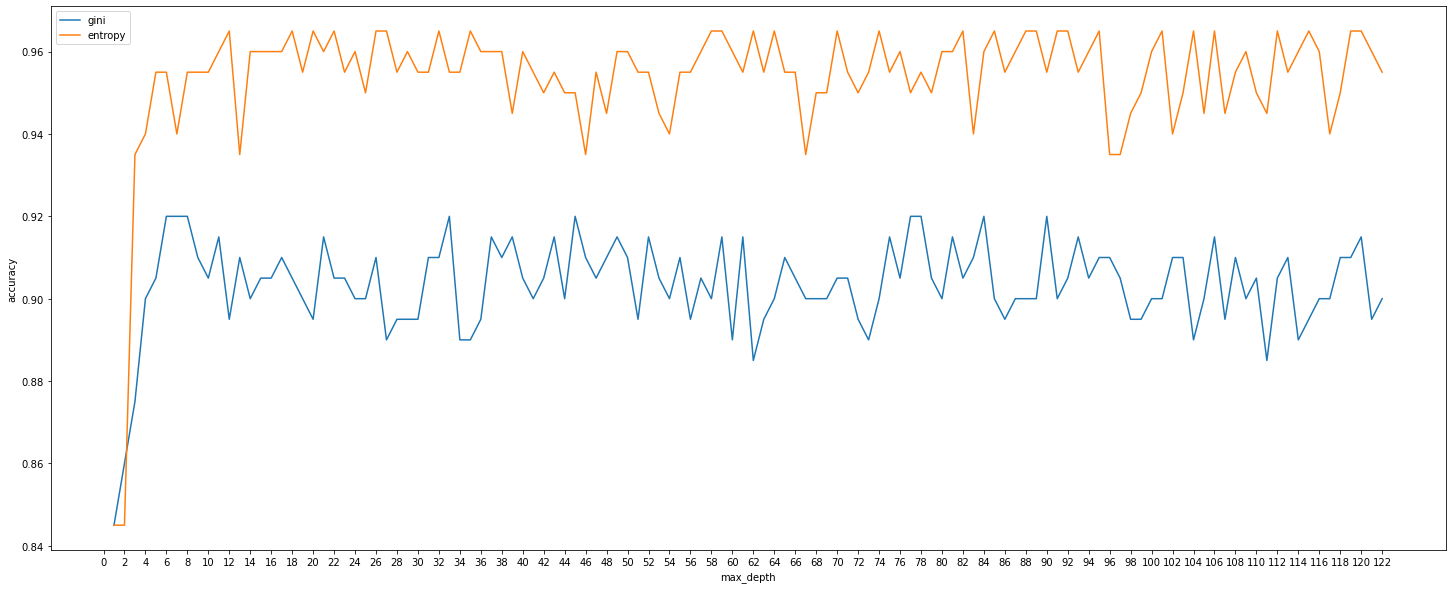

In [52]:
# DT Pruning
max_depth = []
acc_gini = []
acc_entropy = []
for i in range(1, len(OHE_train.columns)):
    dtree = DecisionTreeClassifier(criterion='gini', max_depth=i)
    dtree.fit(OHE_train, y_train)
    pred = dtree.predict(OHE_test)
    acc_gini.append(accuracy_score(y_test, pred))
####
    dtree = DecisionTreeClassifier(criterion='entropy', max_depth=i)
    dtree.fit(OHE_train, y_train)
    pred = dtree.predict(OHE_test)
    acc_entropy.append(accuracy_score(y_test, pred))
####
    max_depth.append(i)
d = pd.DataFrame({'acc_gini':pd.Series(acc_gini), 'acc_entropy':pd.Series(acc_entropy),'max_depth':pd.Series(max_depth)})

# visualizing changes in parameters
plt.figure(figsize = (25, 10))
plt.plot('max_depth','acc_gini', data=d, label='gini')
plt.plot('max_depth','acc_entropy', data=d, label='entropy')
plt.xticks(np.arange(0, len(OHE_train.columns), 2))
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.legend()

In [66]:
# Evaluate Model 
dtree = DecisionTreeClassifier(criterion='entropy', max_depth= 8)
dtree.fit(OHE_train, y_train)
y_predict = dtree.predict(OHE_test)

report = """
The evaluation report is:
Confusion Matrix:
{}
Accuracy: {}
""".format(confusion_matrix(y_test, y_predict),
           accuracy_score(y_test, y_predict))
print(report)


The evaluation report is:
Confusion Matrix:
[[ 63   6]
 [  3 128]]
Accuracy: 0.955



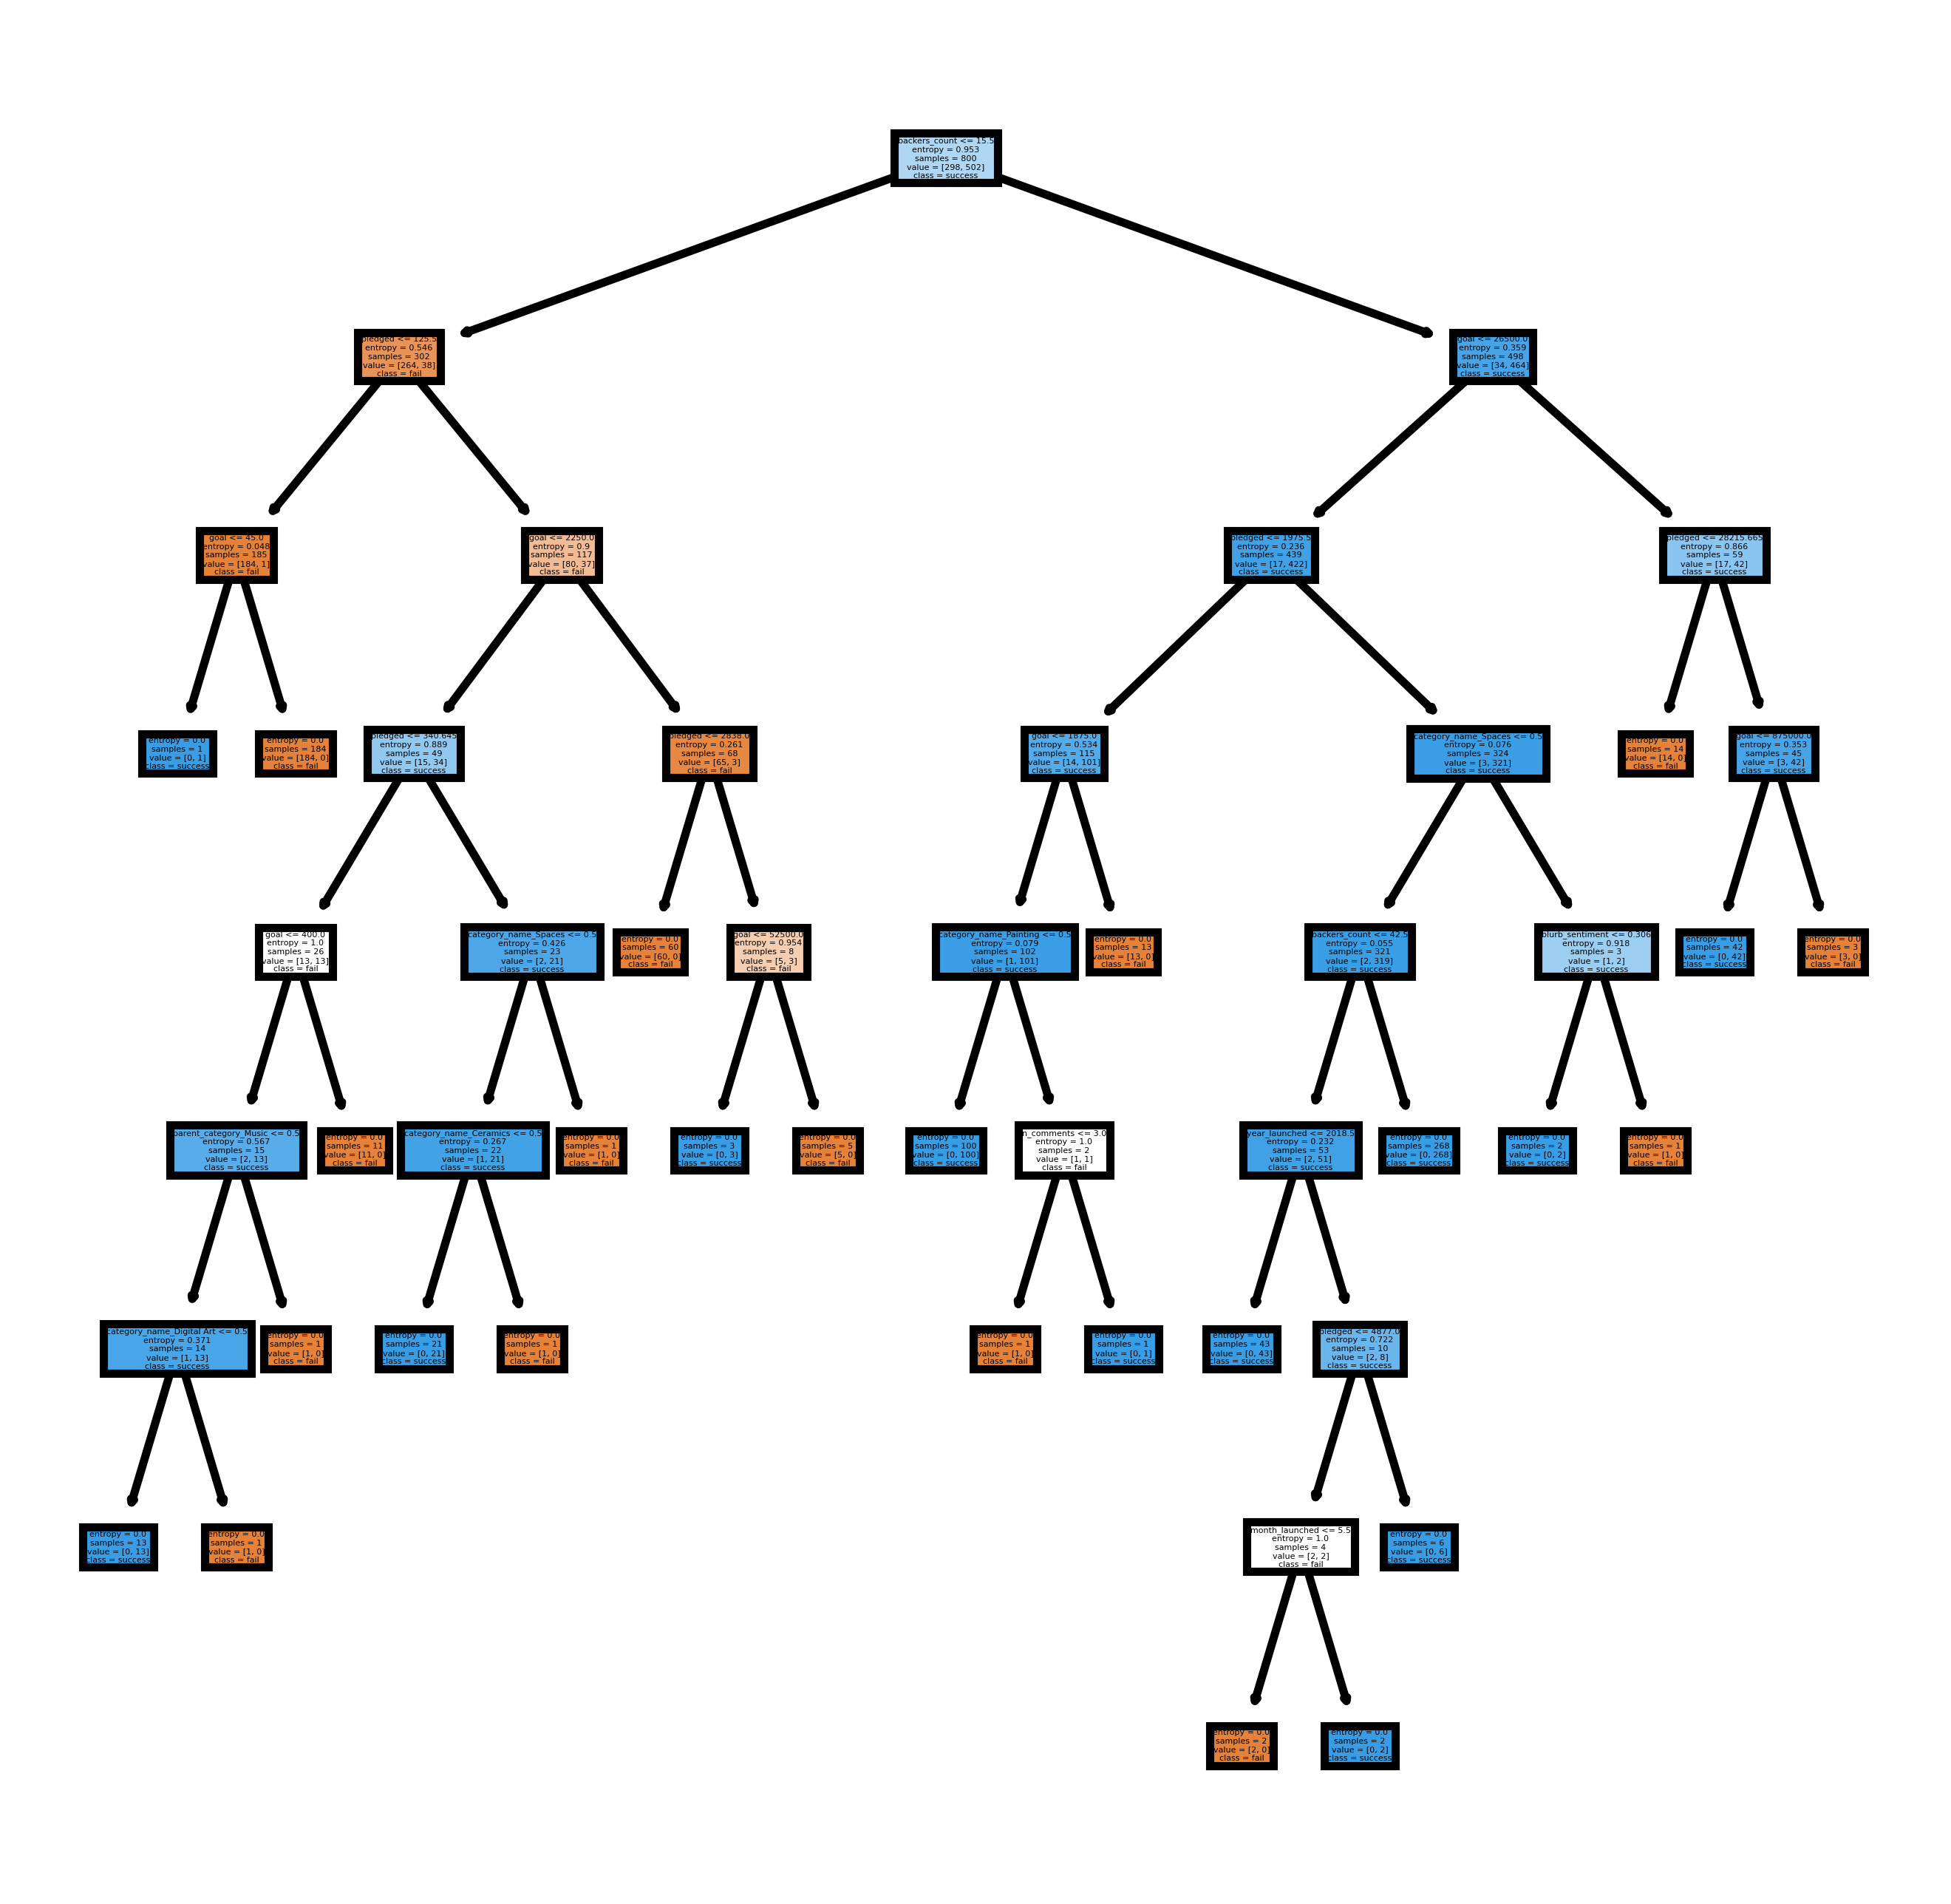

In [67]:
feature_list = list(OHE_train.columns)
cn = ['fail', 'success']

fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
tree.plot_tree(dtree,
               feature_names = feature_list, 
               class_names = cn,
               filled = True)
fig.savefig('dtree.png')

### DecisionTreeRegressor

In [80]:
# Build Model
x_reg = OHE_train
y_reg = y_train

dt_reg_estimator = tree.DecisionTreeRegressor()
dt_reg_estimator.fit(x_reg, y_reg)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   backers_count       1000 non-null   int64  
 1   country             1000 non-null   object 
 2   fx_rate             1000 non-null   float64
 3   goal                1000 non-null   int64  
 4   pledged             1000 non-null   float64
 5   staff_pick          1000 non-null   bool   
 6   state               1000 non-null   int8   
 7   usd_type            1000 non-null   object 
 8   num_faq             1000 non-null   int32  
 9   n_comments          1000 non-null   float64
 10  duration            1000 non-null   int8   
 11  month_launched      1000 non-null   int64  
 12  year_launched       1000 non-null   int64  
 13  parent_category     1000 non-null   object 
 14  category_name       1000 non-null   object 
 15  blurb_sentiment     1000 non-null   float64
 16  name_se

DecisionTreeRegressor()

In [81]:
# Model Evaluation
y_reg_predict = dt_reg_estimator.predict(OHE_test)
print('MSE: {}'.format(mean_squared_error(y_test, y_reg_predict)))

MSE: 0.07
